In [7]:
# nltk
import nltk
# gensim
import gensim
import gensim.corpora as corpora
# spacy
import spacy
#vis
import pyLDAvis
import pyLDAvis.gensim

In [2]:
import pandas as pd

In [3]:
db_init = pd.read_csv("C:/Users/valentin.stuhlfauth/OneDrive - univ-lyon2.fr/2_2025-DUT systematic review/2_Topic modelling/0_code/2025_Pol4PED_systematic_review/0_data/2025-02-27_Screening_result.csv",sep=';',encoding='ISO-8859-1')

db_init=db_init.reset_index()
data=db_init[db_init["Approach"].isin(['Conceptual', 'Methodological', 'Qualitative'])]

df_text = pd.DataFrame()
df_text["text_topic"] = data["Article Title"] + " " + data["Abstract"]
df_text = df_text["text_topic"]

## Pretreatment

### Lemmatisation, generation and bigrams

In [4]:
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)

In [5]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

In [8]:
data_words = gen_words(lemmatization(df_text))

## Using Keyphrase Extraction (YAKE, RAKE, or TextRank)

In [38]:
import spacy
from gensim.models import Phrases

# Provided lemmatization function, but skipping key terms like "Low Carbon Cities"
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"], special_terms=None):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    
    # If special terms are provided, we'll keep them as they are
    if special_terms is None:
        special_terms = []

    for text in texts:
        doc = nlp(text)
        new_text = []
        
        # First, handle special terms
        for term in special_terms:
            if term.lower() in text.lower():  # Case-insensitive match
                text = text.replace(term, term.lower())  # Replace with lowercase for easier matching
        
        # Lemmatize the rest of the text
        doc = nlp(text)
        for token in doc:
            if token.pos_ in allowed_postags and token.text.lower() not in special_terms:
                new_text.append(token.lemma_)
            elif token.text.lower() in special_terms:
                new_text.append(token.text)  # Keep special terms unchanged
        
        final = " ".join(new_text)
        texts_out.append(final)
    
    return texts_out

# Define a list of special terms you want to preserve (e.g., "Low Carbon Cities")
special_terms = ["Low Carbon Cities", "Zero Emission Neighborhoods", "Net Zero Transport Planning"]

# Apply lemmatization to the text (title + abstract), keeping special terms
lemmatized_texts = lemmatization(df_text, special_terms=special_terms)

# Tokenize sentences into words
sentences = [text.split() for text in lemmatized_texts]

# Detect bigrams (two-word phrases)
bigram = Phrases(sentences, min_count=5, threshold=10)

# Apply the bigram model to sentences
bigram_mod = Phrases(sentences, min_count=5, threshold=10)
bigram_mod = gensim.models.phrases.Phraser(bigram_mod)  # Convert to Phraser for faster processing

# Detect trigrams (three-word phrases) using bigrams first
trigram = Phrases(bigram_mod[sentences], threshold=10)
trigram_mod = gensim.models.phrases.Phraser(trigram)  # Convert to Phraser for faster processing

# Extract multi-word expressions (concepts)
concepts = set()
for sent in sentences:
    for phrase in trigram_mod[bigram_mod[sent]]:  # Apply both bigram and trigram models
        if "_" in phrase:  # Filter only multi-word expressions
            concepts.add(phrase.replace("_", " "))  # Replace underscore with space

# Output the detected concepts
print(concepts)

{'sustainable mobility', 'natural carbon sink', 'energy vulnerability', 'greenhouse gas emission', 'action plan', 'industrialization urbanization', 'residential building', 'renewable energy generation', 'index system', 'as well', 'urban area', 'low carbon society', 'economic growth', 'low carbon urbanization', 'techno economic', 'virtual reality', 'low carbon transport', 'emission reduction', 'valuable insight', 'resource dependent', 'pilot project', 'pilot policy', 'low pollution', 'c publish peer review', 'energy transition', 'land use pattern', 'renewable electricity', 'low carbon urban', 'intensity reduction', 'home abroad', 'help achieve', 'european project', 'health idea', 'residential area', 'smart city', 'business usual', 'innovative technology', 'total energy consumption', 'urbanization process', 'practical application', 'fast grow', 'achieve net', 'spatial planning', 'about %', 'renewable source', 'little attention', 'rapid growth', 'mixed use', 'socio ecological', 'urban ren

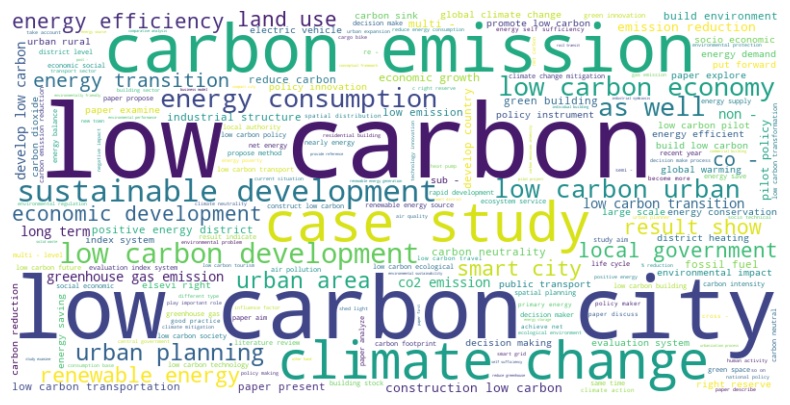

                     Concept  Number of Citations
12                low carbon                  643
1            low carbon city                  616
70           carbon emission                  336
46                case study                  212
2             climate change                  196
66   sustainable development                  191
21    low carbon development                  161
8         low carbon economy                  153
10        energy consumption                  151
19                   as well                  147
5           low carbon urban                  138
62            urban planning                  118
20                urban area                  112
141         renewable energy                  106
357               smart city                  103
49               result show                   90
23      economic development                   86
72                  land use                   84
37         energy efficiency                   83


In [39]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
from collections import defaultdict

# Step 1: Count the number of rows citing each concept
concepts_rows_counter = defaultdict(int)  # A dictionary to count rows for each concept

# Iterate through the lemmatized sentences and count distinct rows citing each concept
for idx, sent in enumerate(sentences):
    for phrase in trigram_mod[bigram_mod[sent]]:  # Apply both bigram and trigram models
        if "_" in phrase:  # Filter only multi-word expressions
            concepts_rows_counter[phrase.replace("_", " ")] += 1  # Increase the count for this concept

# Step 2: Visualize the concepts based on the number of rows citing them

# Convert the dictionary to a DataFrame
concepts_rows_df = pd.DataFrame(concepts_rows_counter.items(), columns=["Concept", "Number of Citations"])

# Sort by the number of citations (descending)
concepts_rows_df = concepts_rows_df.sort_values(by="Number of Citations", ascending=False)

# Plot the word cloud of concepts based on the number of citations (rows)
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(concepts_rows_counter)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Step 3: Display the top concepts based on the number of citations (rows)
print(concepts_rows_df.head(20))  # Adjust as needed to see more or fewer

# Optionally, save the concepts with citation counts for further analysis
concepts_rows_df.to_csv("concepts_with_citations.csv", index=False)

In [40]:
concepts_rows_df

,Concept,Number of Citations
12,low carbon,643
1,low carbon city,616
70,carbon emission,336
46,case study,212
2,climate change,196
...,...,...
630,article cc,1
628,road freight,1
604,peer review responsibility,1
605,- benefit,1
